In [1]:
#Import statments
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torchvision
from PIL import Image
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler
from torch.nn.functional import normalize

In [2]:
# define ANN
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.layer1 = nn.Linear(250*250*3, 600)
        self.layer2 = nn.Linear(600, 50)
        self.layer3 = nn.Linear(50, 5)  

    def forward(self, data):
        flattened = data.reshape(-1, 250 * 250 * 3)
        flattened = normalize(flattened, p=2.0)
        activation1 = F.relu(self.layer1(flattened))
        activation2 = F.relu(self.layer2(activation1))
        output = self.layer3(activation2)
        return output

In [3]:
# load the data
dataset = torchvision.datasets.ImageFolder('/kaggle/input/rice-seeds/bw-rice-imgs', transform=transforms.ToTensor())
dataset_subset = torch.utils.data.Subset(dataset, np.random.choice(len(dataset), 4000, replace=False))

train_dataset, val_dataset = torch.utils.data.random_split(dataset_subset, [0.8,0.2])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)

In [4]:
from matplotlib.cm import datad

#accuracy function
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:
                  
        # To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
#         #img_fix = imgs.transpose(1,3)
#         #img_fix = imgs.permute(0,3,1,2)
        
        #img_fix = torch.reshape(imgs,(1,3,250,250))
        img_fix = imgs
        
        output = model(img_fix)
        # Select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        #print(pred,labels.view_as(pred))
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [5]:
def train(model, train_loader, val_loader, batch_size=64, num_epochs=1 , print_stat = 1):
    #train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    counter = 0 #number of batches
    for epoch in range(num_epochs):
        print("epoch: " + str(epoch + 1))
        epoch_loss = 0
        for imgs, labels in iter(train_loader):
            counter += 1
            
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            
            #img_fix = imgs.transpose(1,3)
            #img_fix = torch.reshape(imgs,(1,3,250,250))
            img_fix = imgs
            out = model(img_fix)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
            epoch_loss += loss.detach().cpu().numpy()

            # save the current training information
        iters.append(n)
        train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy 
        losses.append(epoch_loss)
        val_acc.append(get_accuracy(model, val_loader))  # compute validation accuracy
        print(("Epoch {}: Train acc: {} Val acc: {} Epoch loss: {}").format(
                    epoch + 1,
                    train_acc[epoch],
                    val_acc[epoch],
                    losses[epoch]))
        n += 1
        # save the state of the model and optimizer
        state = {'epoch': epoch, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
        torch.save(state, 'ann_model_checkpoint.pt')

    if print_stat:
      # plotting
      plt.title("Training Curve")
      plt.plot(iters, losses.copy(), label="Train")
      plt.xlabel("Iterations")
      plt.ylabel("Loss")
      plt.show()

      plt.title("Training Curve")
      plt.plot(iters, train_acc, label="Train")
      plt.plot(iters, val_acc, label="Validation")
      plt.xlabel("Iterations")
      plt.ylabel("Training Accuracy")
      plt.legend(loc='best')
      plt.show()

      print("Final Training Accuracy: {}".format(train_acc[-1]))
      print("Final Validation Accuracy: {}".format(val_acc[-1]))

CUDA is available!  Training on GPU ...
epoch: 1
Epoch 1: Train acc: 0.4765625 Val acc: 0.5 Epoch loss: 74.9978551864624
epoch: 2
Epoch 2: Train acc: 0.6828125 Val acc: 0.6875 Epoch loss: 57.61265915632248
epoch: 3
Epoch 3: Train acc: 0.879375 Val acc: 0.88875 Epoch loss: 42.447534024715424
epoch: 4
Epoch 4: Train acc: 0.9021875 Val acc: 0.90875 Epoch loss: 31.534687936306
epoch: 5
Epoch 5: Train acc: 0.9171875 Val acc: 0.93 Epoch loss: 23.658274918794632
epoch: 6
Epoch 6: Train acc: 0.923125 Val acc: 0.92875 Epoch loss: 18.506342321634293
epoch: 7
Epoch 7: Train acc: 0.9265625 Val acc: 0.9375 Epoch loss: 15.271694600582123
epoch: 8
Epoch 8: Train acc: 0.931875 Val acc: 0.94125 Epoch loss: 13.070283278822899


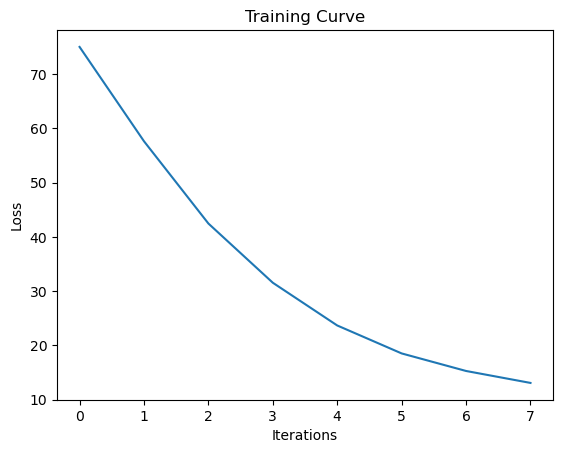

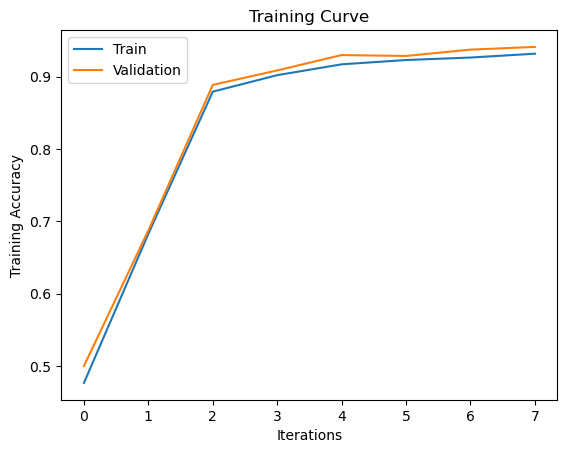

Final Training Accuracy: 0.931875
Final Validation Accuracy: 0.94125


In [6]:
#Create model, run
riceClassifier = ANN()

use_cuda = True

if use_cuda and torch.cuda.is_available():
  riceClassifier.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(riceClassifier, train_loader, val_loader, batch_size=32, num_epochs=8, print_stat=1)

In [7]:
torch.save(riceClassifier, 'annFinalModel.pt')

In [8]:
import os
os.chdir(r'/kaggle/working')

In [9]:
from IPython.display import FileLink
FileLink(r'annFinalModel.pt')

/kaggle/working/annFinalModel.pt